In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal
from scipy import stats
from scipy.stats import normaltest
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

Оберемо для аналізу дані, де store==1 і item==1

In [3]:
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear
train_df['weekday'] = train['date'].dt.weekday

train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


In [4]:
def plot_df(x, y, xlabel='Date', title = '', ylabel='Value', dpi=150):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

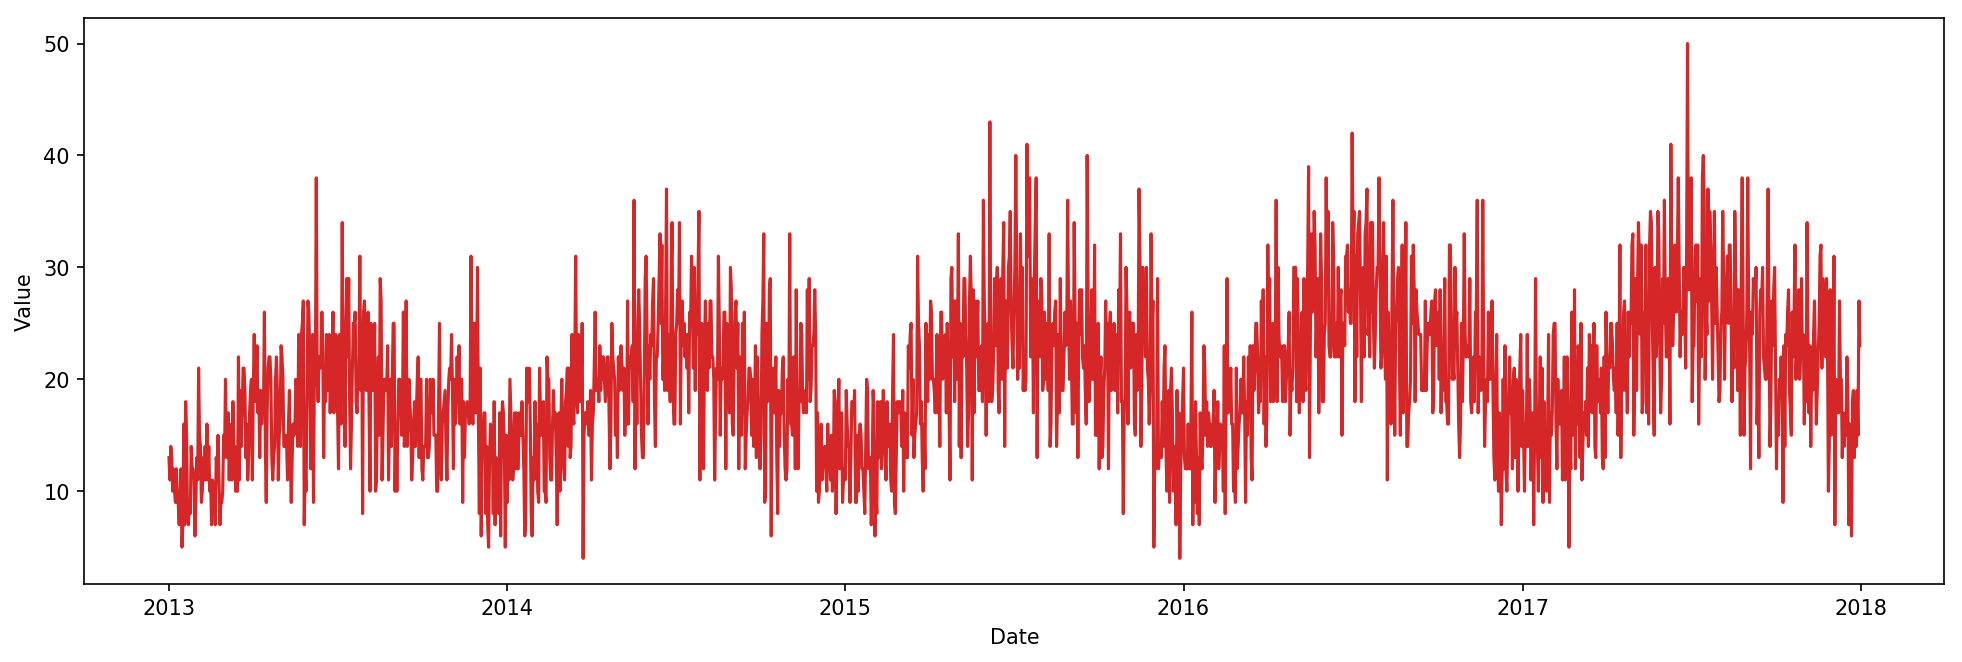

In [5]:
plot_df(train_df.index, train_df.sales)

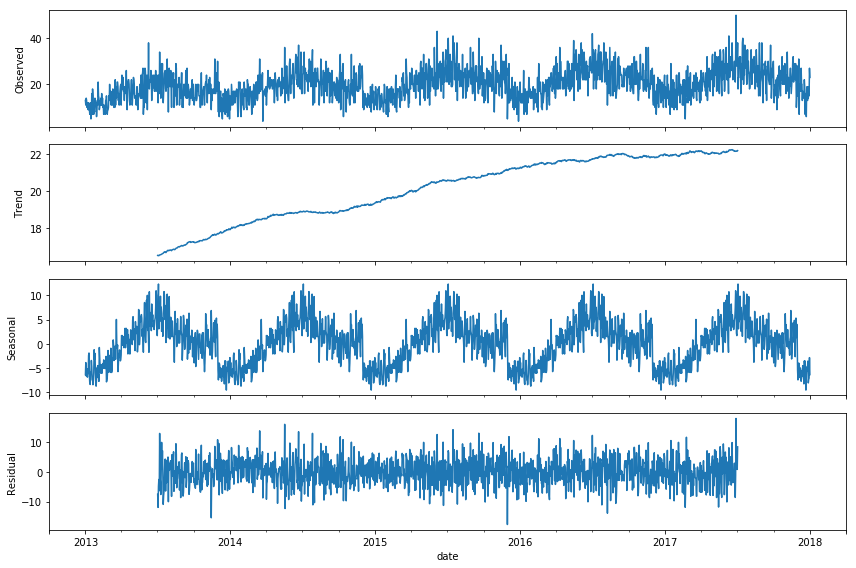

In [21]:
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)
plt.rcParams.update({'figure.figsize': (12,8)})
result.plot()
plt.show()

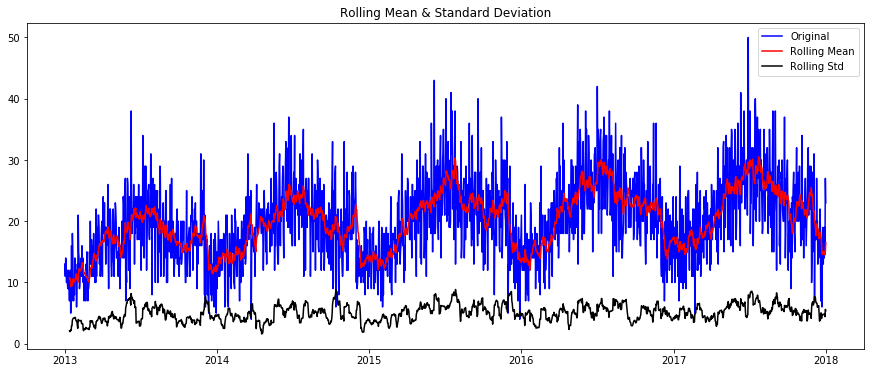

Results of Dickey-Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [7]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    Dickey_Fuller_test(timeseries)
    
def Dickey_Fuller_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(train_df.sales)

p-valuе менше за 0.05, отже можемо сказати, що дані стаціонарні. Але чисто візуально бачимо наявність тренду, тому проведемо логарифмування

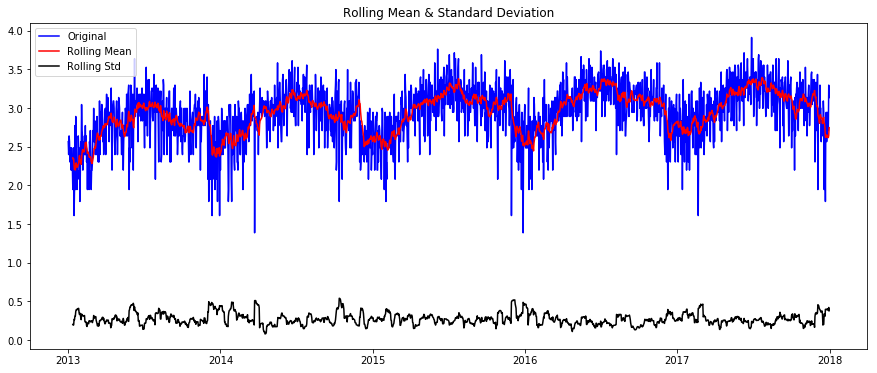

Results of Dickey-Fuller Test:
Test Statistic                   -3.594424
p-value                           0.005869
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [8]:
train_df_log = np.log(train_df)
test_stationarity(train_df_log.sales)

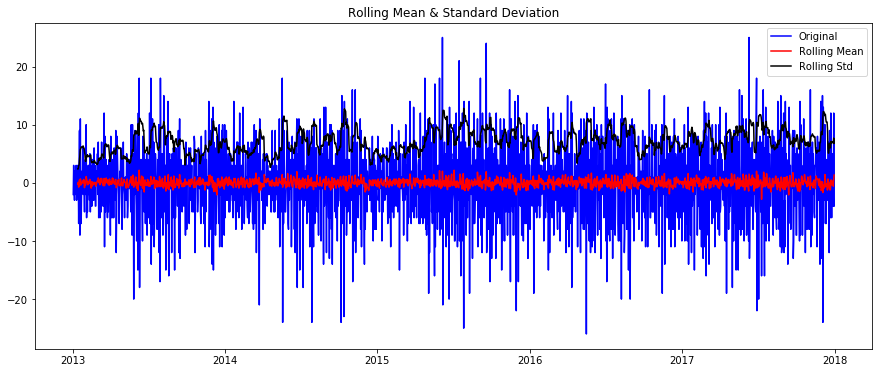

Results of Dickey-Fuller Test:
Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


In [9]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff)

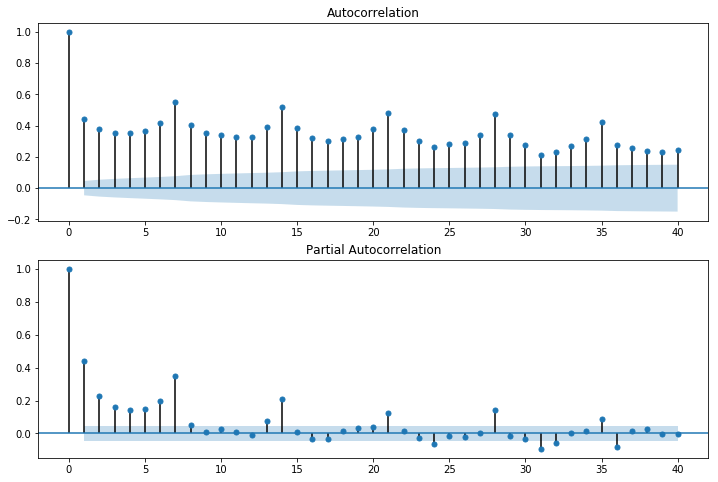

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train_df_log.sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train_df_log.sales, lags=40, ax=ax2)

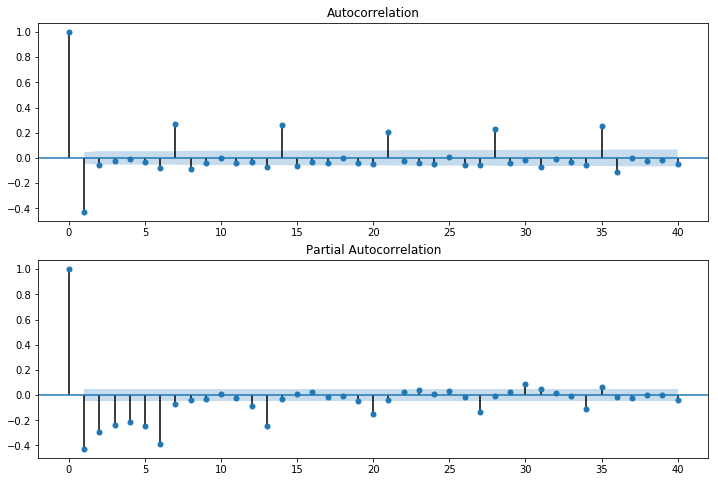

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(first_diff, lags=40, ax=ax2)

In [12]:
p, d, q = 6, 1, 0

### AR

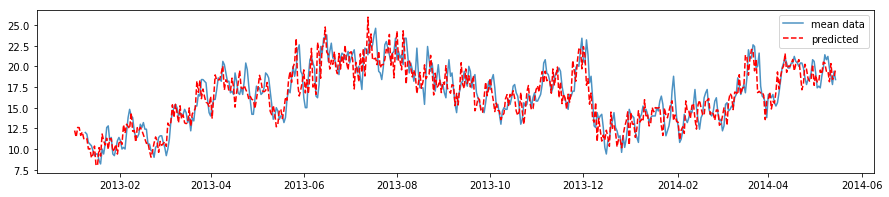

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1826
Model:                     ARMA(6, 0)   Log Likelihood               -5750.391
Method:                       css-mle   S.D. of innovations              5.636
Date:                Sun, 26 May 2019   AIC                          11514.782
Time:                        21:59:11   BIC                          11553.351
Sample:                    01-01-2013   HQIC                         11529.009
                         - 12-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.sales     0.2756      0.023     12.138      0.000       0.231       0.320
ar.L2.sales     0.1189      0.023      5.082      0.000       0.073       0.165
ar.L3.sales     0.1035      0.023      4.421    

In [102]:
model = ARIMA(train_df.sales, order=(p, 0, q))  
results_ARIMA = model.fit(disp=-1, trend='nc')
predictions_ARIMA= pd.Series(results_ARIMA.fittedvalues, copy=True)
plt.figure(figsize=(15,3))
plt.plot(train_df.sales[1:500].rolling(5).mean().shift(3), alpha=0.8, label='mean data')
plt.plot(predictions_ARIMA[1:500], 'r--', label='predicted')
plt.legend(loc='best')
plt.show()
print(results_ARIMA.summary())

NormaltestResult(statistic=16.69263798997649, pvalue=0.0002372682987271919)


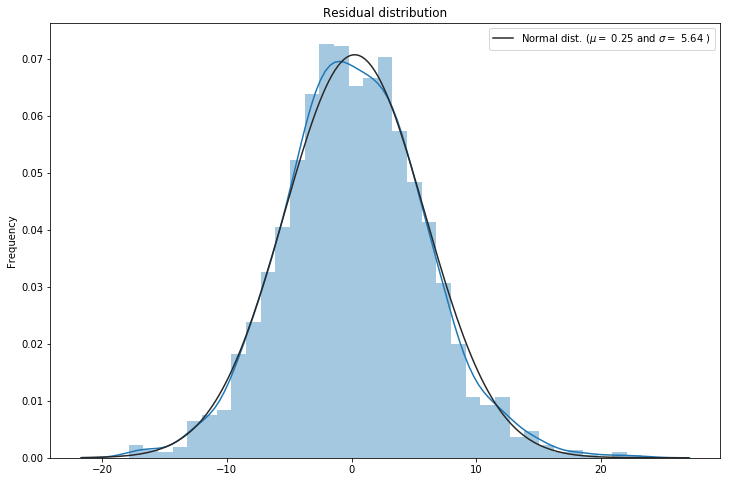

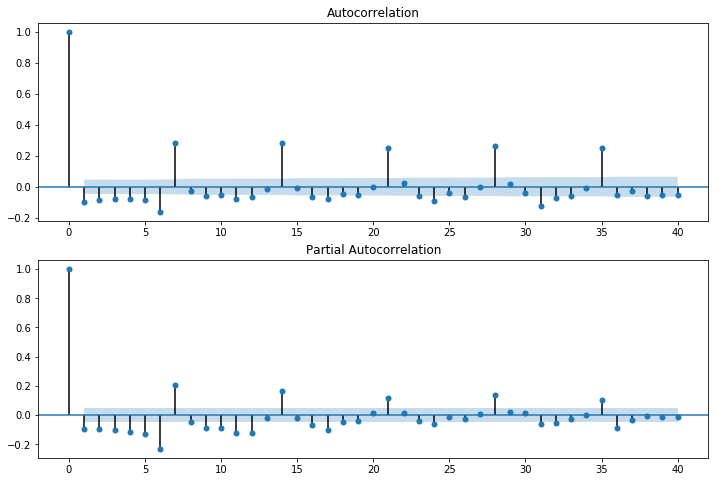

In [103]:
def print_res_dist(model):
    resid = model.resid
    print(normaltest(resid))
    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)
    sns.distplot(resid ,fit = stats.norm, ax = ax0) 
    (mu, sigma) = stats.norm.fit(resid)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(model.resid, lags=40, ax=ax2)
print_res_dist(results_ARIMA)

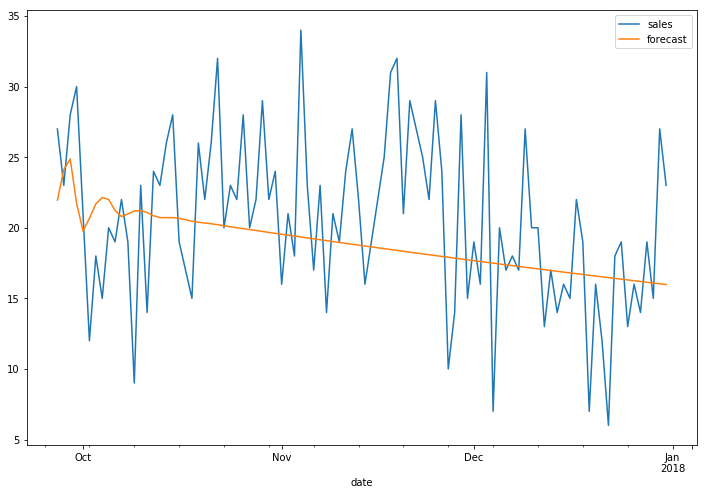

In [104]:
start_index = 1730
end_index = 1826
train_df['forecast'] = results_ARIMA.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

### SARIMAX

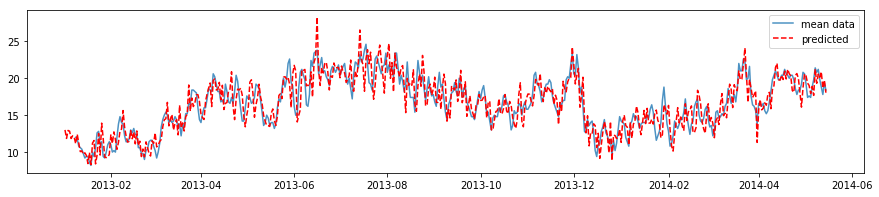

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Sun, 26 May 2019   AIC                          11209.359
Time:                        21:56:11   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

In [85]:
result_SARIMAX = SARIMAX(train_df.sales, trend='n', order=(p, d, q)).fit()
predictions_SARIMAX = pd.Series(result_SARIMAX.fittedvalues, copy=True)
plt.figure(figsize=(15,3))
plt.plot(train_df.sales[1:500].rolling(5).mean().shift(3), alpha=0.8, label='mean data')
plt.plot(predictions_SARIMAX[1:500], 'r--', label='predicted')
plt.legend(loc='best')
plt.show()
print(result_SARIMAX.summary())

NormaltestResult(statistic=16.7426901465306, pvalue=0.00023140408886010178)


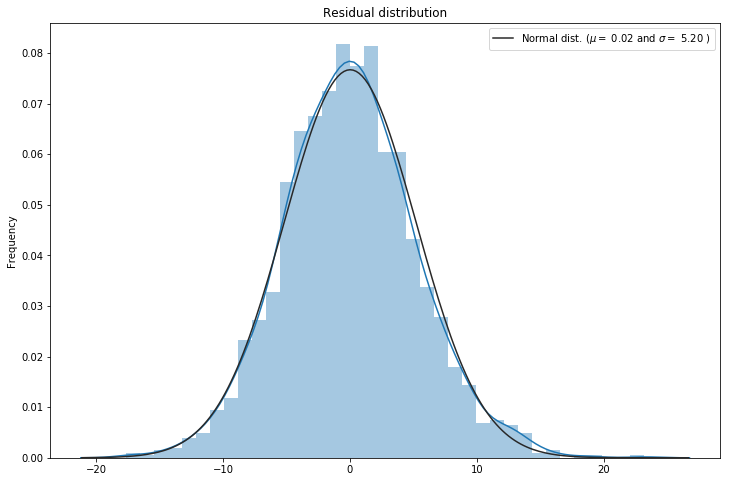

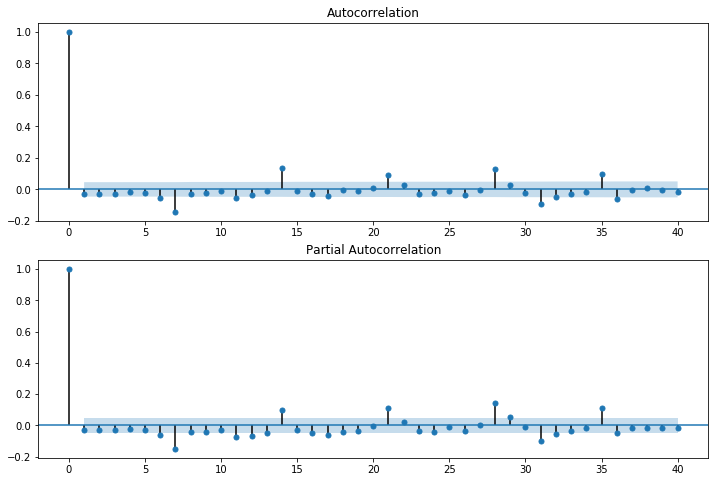

In [86]:
print_res_dist(result_SARIMAX)

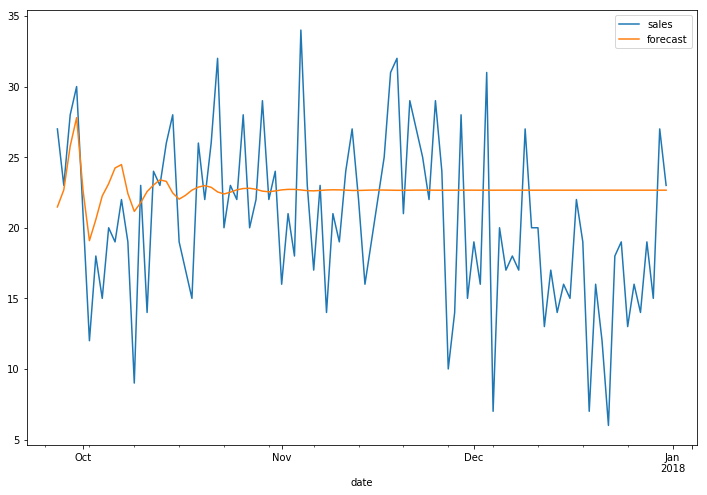

In [87]:
start_index = 1730
end_index = 1826
train_df['forecast'] = result_SARIMAX.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))